In [3]:
import time
import os

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision
from torchvision import transforms

import PIL
from PIL import Image
import matplotlib.pyplot as plt
from collections import OrderedDict

from utility.utility import *
from utility.vgg_network import *

In [14]:
class Gram_Matrix_Original(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2)) 
        return G    

# Get network
vgg = VGG()
vgg.load_state_dict(torch.load('../../Models/vgg_conv.pth'))
for param in vgg.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    vgg.cuda()

# Get image paths
# Style with serifs
style_path1 = '../../input/serif_fonts/old_inputs/'
style_name1 = 'Birmingham.bmp'
style_dir1 = style_path1 + style_name1

# Style that lacks serifs
style_path2 = '../../input/serif_fonts/old_inputs/'
style_name2 = 'BirminghamSansSerif.bmp'
style_dir2 = style_path2 + style_name2

# Content 
content_path = '../../input/serif_fonts/old_inputs/'
content_name = 'Souci Sans NF.bmp'
content_dir = content_path + content_name

style_image1, style_image2, content_image, opt_img = load_images(style_dir1, style_dir2, content_dir)

# Define layers, loss functions, weights and compute optimization targets
style_layers = ['r11','r21','r31','r41','r51'] 
content_layers = ['r42']
loss_layers = style_layers + content_layers
loss_functions = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
if torch.cuda.is_available():
    loss_functions = [loss_fn.cuda() for loss_fn in loss_functions]

# Recommended weight settings by LeonGatys:
style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
content_weights = [0,0,0,1e5,0]
weights = style_weights + content_weights

# Compute optimization targets
### Style targets 
# Gram matrices of 1st style
style_targets1 = [GramMatrix()(A).detach() for A in vgg(style_image1, style_layers)]
# Gram matrices of 2nd style
style_targets2 = [GramMatrix()(A).detach() for A in vgg(style_image2, style_layers)]
# Feature responces of 1st style
style_content1 = [A.detach() for A in vgg(style_image1, content_layers)]
# Feature responces of 2nd style
style_content2 = [A.detach() for A in vgg(style_image2, content_layers)]
style_targets = []
for i in range(len(style_targets1)):
    style_targets.append((style_targets2[i] - style_targets1[i]))
style_content = []
for i in range(len(style_content1)):
    style_content.append((style_content2[i] - style_content1[i]))
### Content targets
# Feature responces of content
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
# Gram matrices of content
content_styles  = [GramMatrix()(A).detach() for A in vgg(content_image, style_layers)]

In [48]:
def gm_layer(gm_of_layer, iter_n, output_path):
    layer_names=['style 1', 'style 2','style diff', 'content', 'optimized', 'content optimized diff']
    
    # plot with 6 subplots
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(21,14))
    plt.suptitle("GG", fontsize=40)
    for i in range(len(gm_of_layer)):
        gm_of_layer[i] = gm_of_layer[i].squeeze()
        
#         gm_of_layer[i] = gm_of_layer[i].div(60000)
        
        if torch.cuda.is_available():
            gm_of_layer[i] = gm_of_layer[i].cpu().numpy()
        else:
            gm_of_layer[i] = gm_of_layer[i].numpy()
        gm_of_layer[i] = gm_of_layer[i].astype(int)
        # print gram matrices
        plt.subplot(2,3,i+1)
        plt.title(layer_names[i])
        plt.imshow(gm_of_layer[i], cmap='bwr')
#         plt.colorbar(mappable=gm_of_layer[0])

    # add colorbar
    plt.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    plt.colorbar(cax=cbar_ax)
    plt.show()
#     plt.savefig(output_path+'/{}.png'.format(iter_n))
    plt.close()

def visualize_gram_matrices(s1_gram_list, s2_gram_list, s_diff_gram_list, c_gram_list, o_gram_list, co_diff_gram_list, iter_n, output_path):

    s1 = s1_gram_list.copy()
    s2 = s2_gram_list.copy()
    c  = c_gram_list.copy()
    o  = o_gram_list.copy()
    s_diff = s_diff_gram_list.copy()
    co_diff = co_diff_gram_list.copy()
    
    for i in range(len(s1)):
        gm_layer([s1[i], s2[i], s_diff[i], c[i], o[i], co_diff[i]],iter_n, output_path+'/layer{}'.format(i+1))
        

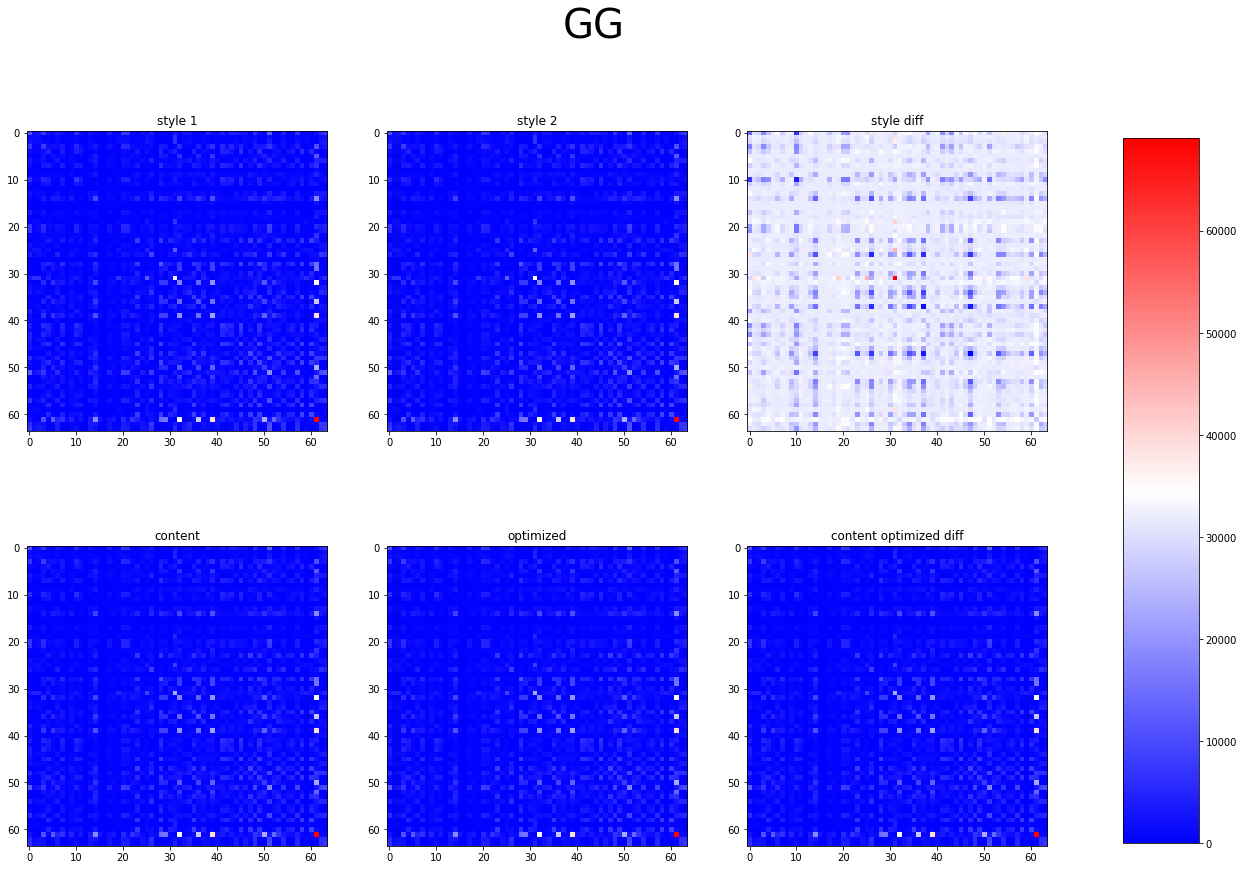

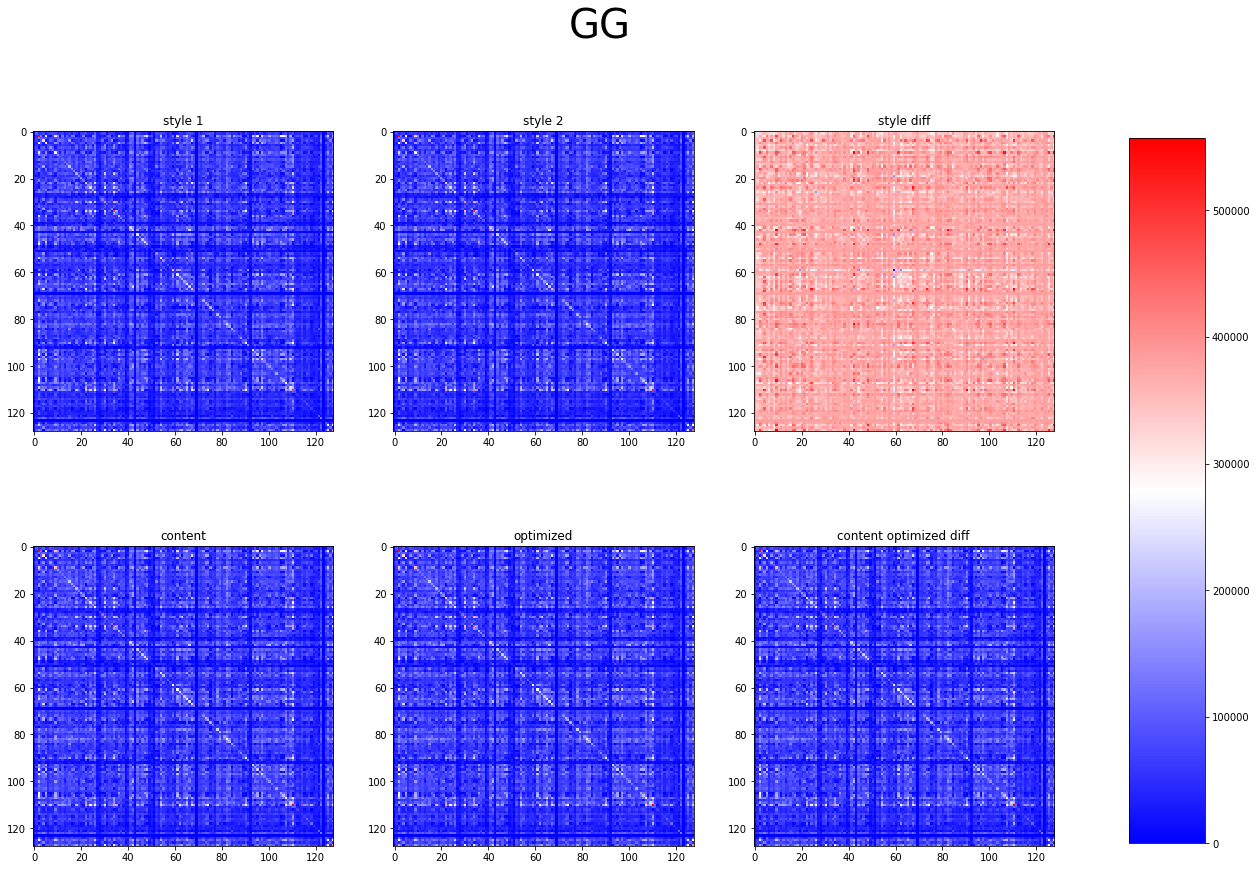

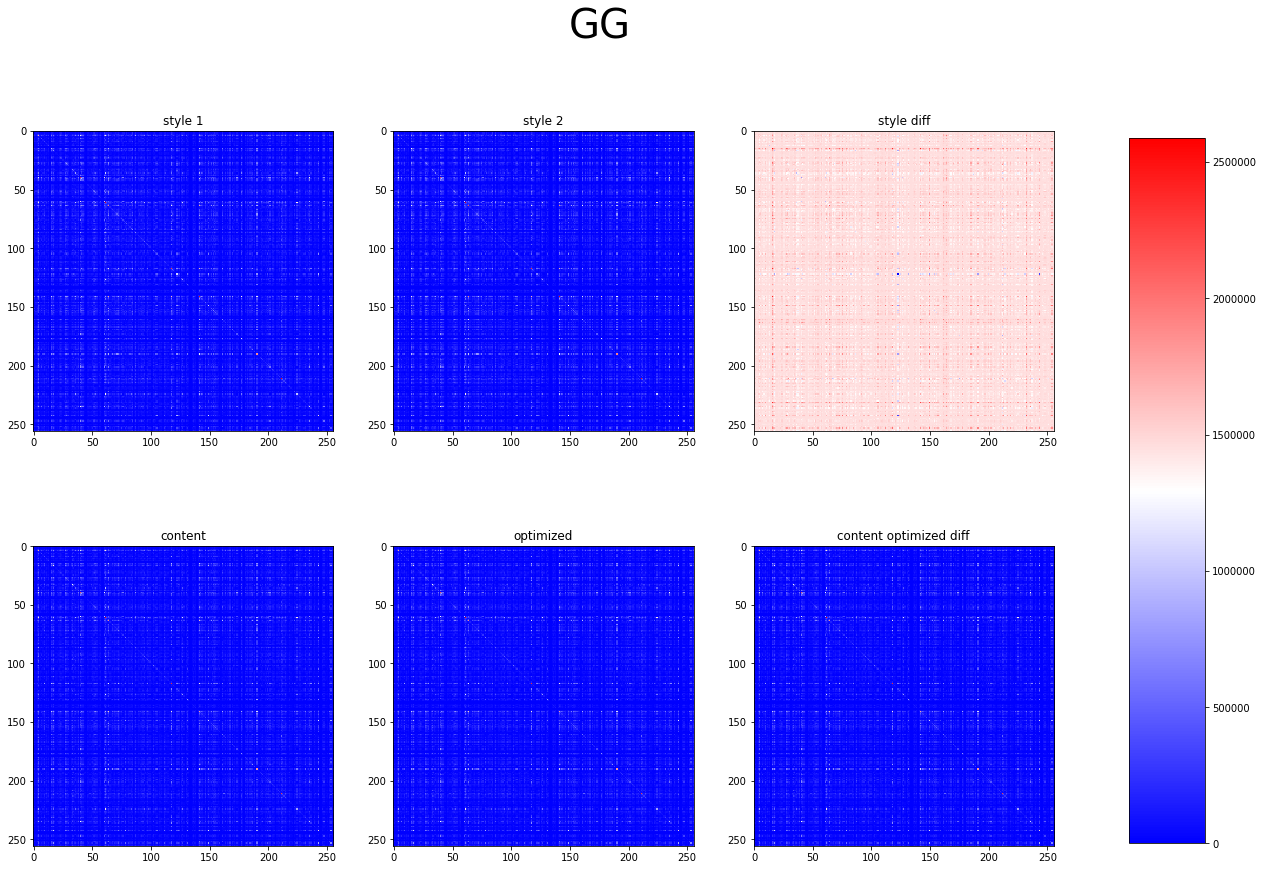

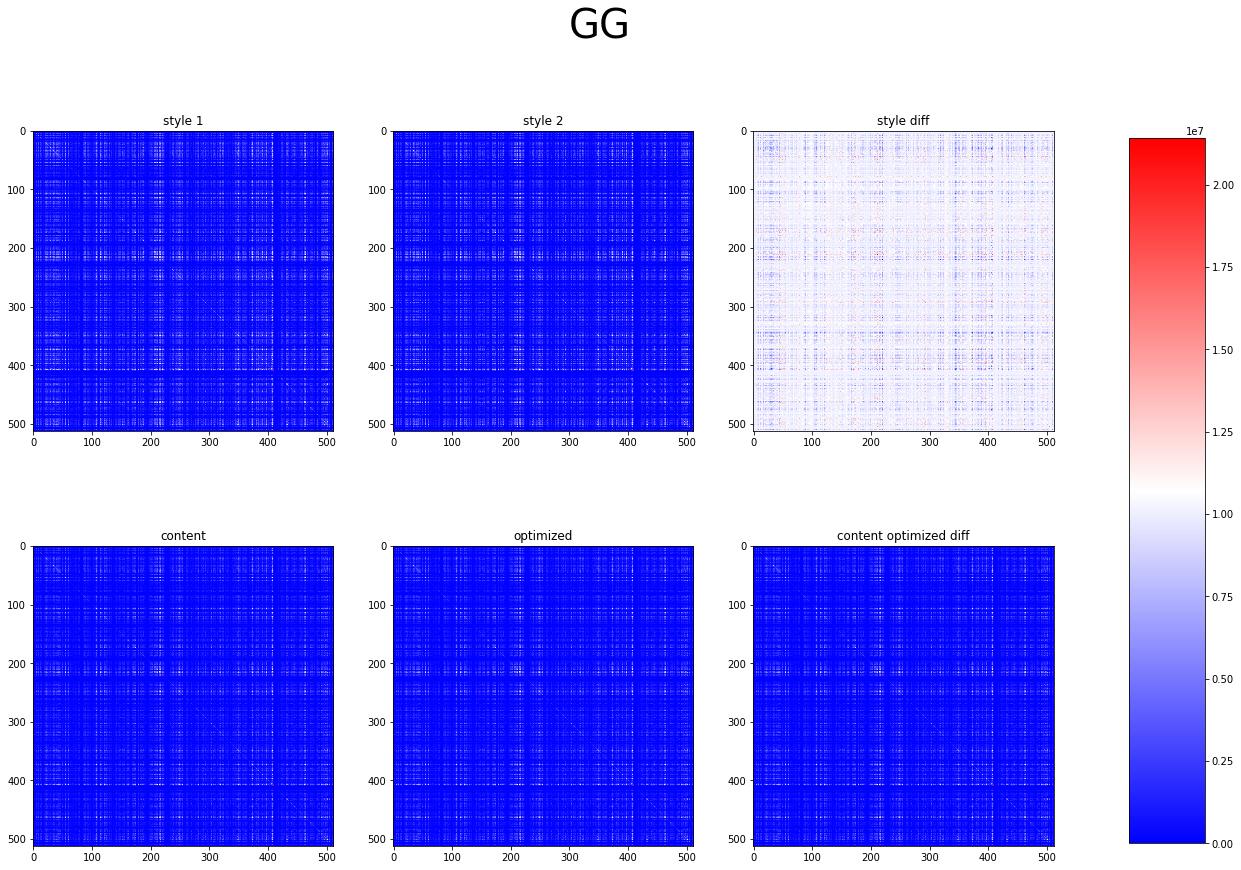

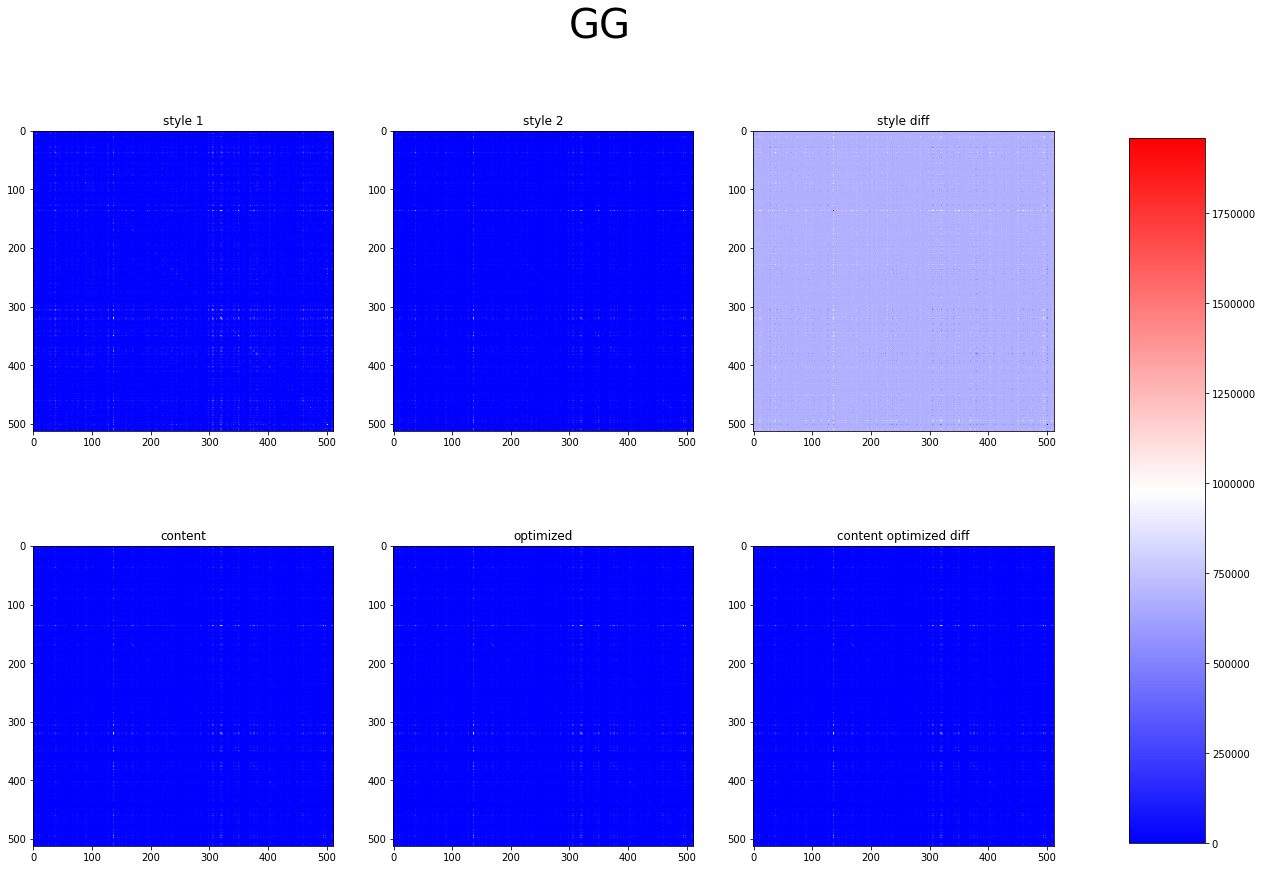

In [49]:
visualize_gram_matrices(style_targets1,style_targets2,style_targets,content_styles,content_styles,content_styles,5, '')

# Make gif from results

In [64]:
path = '../../output_from_pytorch/exp/L730-Sans-Regular_Birmingham_BirminghamSansSerif'

In [104]:
path_outputs = path + '/outputs/'

In [105]:
path_gm_layer1 = path + '/gm_layer1/'

In [110]:
def save_as_gif(input_path, output_path, max_iter, show_iter,filetype='bmp', savename='all.gif'):
    images = []
    for i in range(0, max_iter+1, show_iter):
        image = Image.open(input_path + '/{}.'.format(i) + filetype)
        images.append(image)
    images[0].save(output_path + savename,
               save_all=True, append_images=images[1:], optimize=False, duration=120, loop=0)

In [111]:
save_as_gif(path_gm_layer1, '', 40, 2, filetype='png', savename='layer1.gif')